# Deep Learning &mdash; Assignment 2

Second assignment for the 2021 Deep Learning course (NWI-IMC058) of the Radboud University.

_Twan van Laarhoven (tvanlaarhoven@cs.ru.nl) and Gijs van Tulder (g.vantulder@cs.ru.nl)_

_September 2021_

-----

**Names:** Ilias Mourikis, Reza Shokrzad

**Group:** 50

-----

**Instructions:**
* Fill in your names and the name of your group.
* Answer the questions and complete the code where necessary.
* Keep your answers brief, one or two sentences is usually enough.
* Re-run the whole notebook before you submit your work.
* Save the notebook as a PDF and submit that in Brightspace together with the `.ipynb` notebook file.
* The easiest way to make a PDF of your notebook is via File > Print Preview and then use your browser's print option to print to PDF.

## Objectives

In this assignment you will
1. Learn how to define and train a neural network with pytorch
2. Experiment with convolutional neural networks
3. Investigate the effect of dropout and batch normalization

## Required software

If you haven't done so already, you will need to install the following additional libraries:
* `torch` and `torchvision` for PyTorch,
* `d2l`, the library that comes with [Dive into deep learning](https://d2l.ai) book,
* `sounddevice` to play audio (this is not strictly needed),
* `python_speech_features` to compute MFCC features.

All libraries can be installed with `pip install`.

In [ ]:
!sudo apt-get install libportaudio2
!pip install sounddevice
!pip install d2l

In [2]:
%matplotlib inline
import os
import numpy as np
from d2l import torch as d2l
import torch
from torch import nn
from scipy.io import wavfile

## 2.1 Digits dataset

The d2l book uses a dataset of images as a running example (FashionMNIST). In this assignment we will investigate CNNs in a completely different domain: speech recognition.

The dataset we use is the free spoken digits dataset, which can be found on https://github.com/Jakobovski/free-spoken-digit-dataset. This dataset consists of the digits 0 to 9, spoken by different speakers. The data comes as .wav files.

**(A) Use `git clone` to download the dataset.**

In [3]:
!git clone https://github.com/Jakobovski/free-spoken-digit-dataset.git

Cloning into 'free-spoken-digit-dataset'...
remote: Enumerating objects: 4185, done.
remote: Counting objects: 100% (513/513), done.
remote: Compressing objects: 100% (513/513), done.
remote: Total 4185 (delta 4), reused 501 (delta 0), pack-reused 3672
Receiving objects: 100% (4185/4185), 30.44 MiB | 25.72 MiB/s, done.
Resolving deltas: 100% (81/81), done.


Below is a function to load the data. We pad/truncate each sample to the same length.
The raw audio is usually stored in 16 bit integers, with a range -32768 to 32767, where 0 represents no signal. Before using the data, it should be normalized. A common approach is to make sure that the data is between 0 and 1, between -1 and 1, or zero-mean unit-variance.  Not all of these work well on this data, so later on, if your
network doesn't seem to learn anything: try a different method to see if that works better.

**(B) Update the below code to normalize the data to a reasonable range**

In [4]:
samplerate = 8000

def load_waveform(file, size = 6000):
    samplerate, waveform = wavfile.read(file)
    # Take first 6000 samples from waveform. With a samplerate of 8000 that corresponds to 3/4 second
    # Pad with 0s if the file is shorter
    waveform = np.pad(waveform,(0,size))[0:size]
    # Normalize waveform
    # TODO: Your code here.
    waveform = (waveform - np.mean(np.array(waveform))) / np.std(np.array(waveform))
    return waveform


The following code loads all .wav files in a directory, and makes it available in a pytorch dataset.

**(C) Load the data into a variable `data`**

In [5]:
class SpokenDigits(torch.utils.data.Dataset):
    def __init__(self, data_dir):
        digits_x = []
        digits_y = []
        for file in os.listdir(data_dir):
            if file.endswith(".wav"):
                waveform = load_waveform(os.path.join(data_dir, file))
                label = int(file[0])
                digits_x.append(waveform)
                digits_y.append(label)
        # convert to torch tensors
        self.x = torch.from_numpy(np.array(digits_x, dtype=np.float32))
        self.x = self.x.unsqueeze(1) # One channel
        self.y = torch.from_numpy(np.array(digits_y))
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# TODO: Your code here.
# making an object
data = SpokenDigits('/content/free-spoken-digit-dataset/recordings')
print('y.size: ', data.y.size())
print('x.size: ', data.x.size())

y.size:  torch.Size([3000])
x.size:  torch.Size([3000, 1, 6000])


**(D) Describe the dataset: how many samples are there, what is their dimensionality? How many classes are there?**

In [6]:
# TODO: Your answer here.
print('The number of samples: ', data.x.size()[0])
print('The dimentionality size: ', data.x.size()[2])
print('The number of classes: ', len(set(np.array(data.y))))

The number of samples:  3000
The dimentionality size:  6000
The number of classes:  10


Here is code to play samples from the dataset to give you an idea what it "looks" like.

In [7]:
# import sounddevice as sd
# def play(sample):
#     sd.play(sample[0][0], samplerate)
#     print(sample[1])
# play(data[0])

Before continuing, we split the dataset into a training and a test set.

In [8]:
train_prop = 2/3
train_count = int(len(data) * train_prop)
train, test = torch.utils.data.random_split(data, [train_count, len(data)-train_count])

The code above uses 2/3 of the data for training.

**(E) Discuss an advantage and disadvantage of using more of the data for training**

TODO: your answer here.

By using more data for training the model can learn from more data and so become better in classification. Though, by reducing the test size we would not be able to produce accurate results of the network's accuracy in classification.

Finally, we split the data into batches:

In [9]:
data_params = {'batch_size': 32}
train_iter = torch.utils.data.DataLoader(train, **data_params)
test_iter  = torch.utils.data.DataLoader(test,  **data_params)

## 2.2 One dimensional convolutional neural network

We will now define a network architecture. We will use a combination of convolutional layers and pooling.
Note that we use 1d convolution and pooling here, instead of the 2d operations used for images.

**(A) Complete the network architecture, look at the d2l book chapters 6 and 7 for examples**

In [10]:
net = torch.nn.Sequential(
    nn.Conv1d(1, 4, kernel_size=5), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),

    # TODO: Add three more convolutional layers, ReLU layers and pooling layers;
    #       doubling the number of channels each time
    nn.Conv1d(4, 8, kernel_size=5), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),
    nn.Conv1d(8, 16, kernel_size=5), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),
    nn.Conv1d(16, 32, kernel_size=5), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),
    # TODO: Your code here.
    nn.Flatten(),
    nn.Linear(11872, 128), nn.ReLU(),
    nn.Linear(128, 64), nn.ReLU(),
    nn.Linear(64, 10))

**(B) The first fully connected layer has input dimension 11872, where does that number come from?**

TODO: your answer here

Hint: think about how (valid) convolutional layers and pooling layers with stride affect the size of the data.

As we have filters with size of 5, each conv layer subtracts 4, the dimension of its input. Also, each pooling layer halves the dimension. So, we would have the result like below, after 4 conv and 4 pooling layers.

Input: 6000 $\rightarrow$
conv_1: 5996 $\rightarrow$
pool_1: 2998 $\rightarrow$
conv_2: 2994 $\rightarrow$
pool_2: 1497 $\rightarrow$
conv_3: 1493 $\rightarrow$
pool_3: 746 $\rightarrow$
conv_4: 742 $\rightarrow$
pool_4: 371 $\Rightarrow$
Conv layers output(input of dense layer): 371*32 = 11872


In [11]:
temp = torch.rand(size=(1, 1, 6000), dtype=torch.float32)
for layer in net:
    temp = layer(temp)
    print(layer.__class__.__name__, 'output shape:\t', temp.shape)

Conv1d output shape:	 torch.Size([1, 4, 5996])
ReLU output shape:	 torch.Size([1, 4, 5996])
AvgPool1d output shape:	 torch.Size([1, 4, 2998])
Conv1d output shape:	 torch.Size([1, 8, 2994])
ReLU output shape:	 torch.Size([1, 8, 2994])
AvgPool1d output shape:	 torch.Size([1, 8, 1497])
Conv1d output shape:	 torch.Size([1, 16, 1493])
ReLU output shape:	 torch.Size([1, 16, 1493])
AvgPool1d output shape:	 torch.Size([1, 16, 746])
Conv1d output shape:	 torch.Size([1, 32, 742])
ReLU output shape:	 torch.Size([1, 32, 742])
AvgPool1d output shape:	 torch.Size([1, 32, 371])
Flatten output shape:	 torch.Size([1, 11872])
Linear output shape:	 torch.Size([1, 128])
ReLU output shape:	 torch.Size([1, 128])
Linear output shape:	 torch.Size([1, 64])
ReLU output shape:	 torch.Size([1, 64])
Linear output shape:	 torch.Size([1, 10])


**(C) How many parameters are there in the model? I.e. the total number of weights and biases**

In [12]:
# TODO: Compute the number of parameters
# Hint: use net.parameters() and param.nelement()
print(f'The number of model\'s parameters: \
{sum([param.nelement() for param in net.parameters()])}')

The number of model's parameters: 1532090


**(D) Suppose that instead of using convolutions, we had used only fully connected layers. How many parameters would be needed in that case approximately?**

TODO: your answer here


Since the input in the network is 6000 timesteps long and with aggresive reduction to hidden parameters of the fully connected network, we would have $6 \times 10^3 \times 10^3 = 6 \times 10^6$ parameters. And by taking into account that we have four convolutional layers to replace and also another 3 fully connected, the total approximation of parameters is closer to $7 \times 6 \times 10^6$ parameters. And that is almost 3 times more than a Convolutional Neural Network.

The FashionMNIST dataset used in the book has 60000 training examples. How large is our training set? How would the difference affect the number of epochs that we need? Compare to chapter 6.6 and 7.1 of the book.

**(E) How many epochs do you think are needed?**

In [13]:
lr, num_epochs = 0.01, 100 # TODO: change

We will use the code from the d2l book to train the network.
In particular, the `train_ch6` function, defined in [chapter 6.6](http://d2l.ai/chapter_convolutional-neural-networks/lenet.html#training). This function is available in the `d2l` library.
However, this function has a small bug: it only initializes the weights for 2d convolutional layers, not for 1d convolutional layers.

**(F) Make a copy of the train_ch6 function, and correct the error**

In [14]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    """Compute the accuracy for a model on a dataset using a GPU."""
    if isinstance(net, nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)

    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # Required for BERT Fine-tuning (to be covered later)
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [15]:
def train(net, train_iter, test_iter, num_epochs, lr, device):
    # TODO: your code here (copied and corrected from train_ch6)
    """Train a model with a GPU (defined in Chapter 6)."""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv1d:
            nn.init.xavier_uniform_(m.weight)

    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

**(G) Now train the network.**

loss 0.000, train acc 1.000, test acc 0.651
286.8 examples/sec on cpu


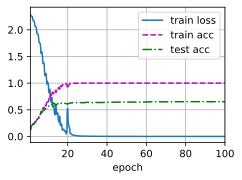

In [16]:
train(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

**(H) Is the training converged?**

**If the training has not converged, maybe you need to change the number of epochs and/or the learning rate.**

Hint: This is a non-trivial problem, so your network might take some time to
learn. Don't give up too quickly, it might take 50-100 epochs before you
see any significant changes in the loss curves.

TODO: Document the changes that you made and their effect. Copy and paste any modified code below.


No, with the setup (epoch=10 and lr=0.01), the model could not converge. But by increasing the number of epochs, converging happened. However, there is the problem of overfitting yet.  

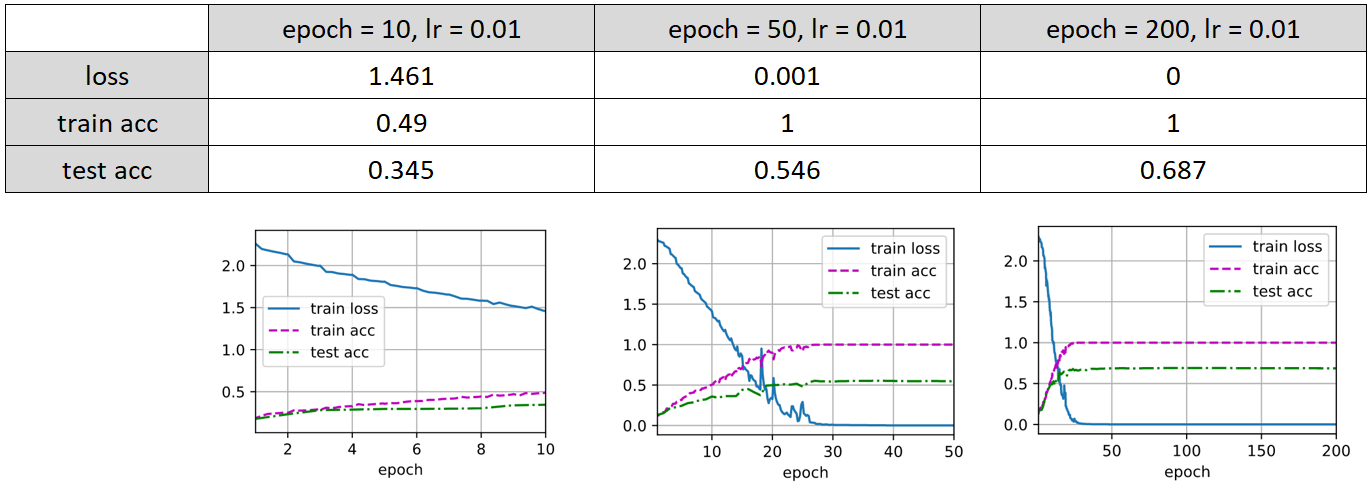

## 2.3 Questions and evaluation

**(A) Does the network look like it is overfitting or underfitting?**

TODO: your answer here

Training led to overfitting because the training accuracy got 100% but this value is almost 0.69% for the test set. It means, the model has learned training data quite well, but it is not sufficiently well for generalizing to test set.

**(B) Is what we have here a good classifier? Could it be used in a realistic application?**

TODO: discuss your answer


No, because of overfitting problem, this model is not an appropriate one to generalize into new data.

**(C) Do you think there is enough training data compared to the dimensions of the data and the number of parameters?**

TODO: your answer here

It can be one of the reasons that the model cannot converge well. In comparison MNIST dataset including (60000 * 28 * 28 = 47,040,000) data, we have just (3000 * 6000 = 18,000,000). So, this amount of data cannot train the same model as well as MNIST.

**(D) How could the classifier be improved?**

TODO: your answer here

There are some typical ways to solve the overfitting problem. Using dropout, batch normalization and data augmentation. Tuning the learning rate, using the lr decay, and changing the architecture of model (the number of nodes and filters, also their size) would be helpful.

**(E) The free spoken digits datasets has recordings from several different speakers. Is the test set accuracy a good measure of how well the trained network would perform for recognizing the voice of a new speaker? And if not, how could that be tested instead?**

TODO: your answer here.

No, it is not. The data includes 50 spoken digits of each speaker. Besides, we have randomly split data. So, there are some spoken digits of the same speaker in both the training and test set. In this term, the test set is not novel for the trained model and the accuracy is higher than what it should be.

## 2.4 Variations

One way in which the training might be improved is with dropout or with batch normalization.

**(A) Make a copy of the network architecture below, and add dropout**

Hint: see [chapter 7.1](http://d2l.ai/chapter_convolutional-modern/alexnet.html#architecture) for an example that uses dropout.

loss 0.127, train acc 0.960, test acc 0.779
308.7 examples/sec on cpu


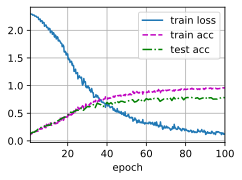

In [19]:
net_dropout = torch.nn.Sequential(
    nn.Conv1d(1, 4, kernel_size=5), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),
    nn.Dropout(0.2),
    nn.Conv1d(4, 8, kernel_size=5), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),
    nn.Dropout(0.2),
    nn.Conv1d(8, 16, kernel_size=5), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),
    nn.Dropout(0.2),
    nn.Conv1d(16, 32, kernel_size=5), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),
    nn.Dropout(0.2),
    # TODO: Your code here.
    nn.Flatten(),
    nn.Linear(11872, 128), nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 64), nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(64, 10)) 

"TODO: your network here"
# train(net_dropout, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

**(B) How does dropout change the results?**

TODO: your answer here

Dropout layers could enhance the test accuracy (from 0.687 to 0.779). They also reduced the overfitting problem that is seen in the decreased gap between the test ad training accuracies.

**(C) Make a copy of the original network architecture, and add batch normalization to all convolutional and linear layers.**

Hint: see [chapter 7.5](http://d2l.ai/chapter_convolutional-modern/batch-norm.html#concise-implementation) for an example.

loss 0.002, train acc 1.000, test acc 0.811
290.8 examples/sec on cpu


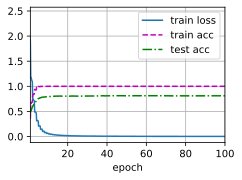

In [20]:
net_batchnorm = torch.nn.Sequential(
    nn.Conv1d(1, 4, kernel_size=5), 
    nn.BatchNorm1d(4),
    nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),

    # TODO: Add three more convolutional layers, ReLU layers and pooling layers;
    #       doubling the number of channels each time
    nn.Conv1d(4, 8, kernel_size=5), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),
    nn.Conv1d(8, 16, kernel_size=5), nn.ReLU(),
    nn.BatchNorm1d(16),
    nn.AvgPool1d(kernel_size=2, stride=2),
    nn.Conv1d(16, 32, kernel_size=5), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),
    # TODO: Your code here.
    nn.Flatten(),
    nn.Linear(11872, 128), nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Linear(128, 64), nn.ReLU(),
    nn.Linear(64, 10))
"TODO: your network here"
train(net_batchnorm, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

**(D) How does batch normalization change the results?**

TODO: your answer here

Additionally, batch normalization can improve the model performance. We could receive 0.811 test accuracy after 100 epochs that show a better result than the original network. A significant change is starting to learn better in the early stages of the training process.

## 2.5 Feature extraction

Given enough training data a deep neural network can learn to extract features from raw data like audio and images. However, in some cases it is still necesary to do manual feature extraction, in particular when working with smaller datasets like this one. For speech recognition, a popular class of features are [MFCCs](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum).

Here is code to extract these features. You will need to install the `python_speech_features` first.

In [21]:
!pip install python_speech_features

  Created wheel for python-speech-features: filename=python_speech_features-0.6-py3-none-any.whl size=5888 sha256=0e2d61e145a2be481092f72d075401287fe2a4bb56816dbee9fc4c5797274311
  Stored in directory: /root/.cache/pip/wheels/b0/0e/94/28cd6afa3cd5998a63eef99fe31777acd7d758f59cf24839eb
Successfully built python-speech-features


In [22]:
from python_speech_features import mfcc

def load_waveform_mfcc(file, size = 6000):
    samplerate, waveform = wavfile.read(file)
    waveform = np.pad(waveform,(0,size))[0:size] / 32768
    return np.transpose(mfcc(waveform, samplerate))

**(A) Implement a variation of the dataset that uses these features**

In [23]:
class SpokenDigitsMFCC(torch.utils.data.Dataset):
    # TODO: Your code here.
    def __init__(self, data_dir):
        digits_x = []
        digits_y = []
        for file in os.listdir(data_dir):
            if file.endswith(".wav"):
                waveform = load_waveform_mfcc(os.path.join(data_dir, file))
                label = int(file[0])
                digits_x.append(waveform)
                digits_y.append(label)
        # convert to torch tensors
        self.x = torch.from_numpy(np.array(digits_x, dtype=np.float32))
        self.x = self.x.unsqueeze(1) # One channel
        self.y = torch.from_numpy(np.array(digits_y))
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


data_mfcc = SpokenDigitsMFCC('/content/free-spoken-digit-dataset/recordings') # TODO: your data directory here
train_count_mfcc = int(len(data_mfcc) * train_prop)
train_mfcc, test_mfcc = torch.utils.data.random_split(data_mfcc, [train_count_mfcc, len(data_mfcc)-train_count_mfcc])
train_iter_mfcc = torch.utils.data.DataLoader(train_mfcc, **data_params)
test_iter_mfcc  = torch.utils.data.DataLoader(test_mfcc,  **data_params)

The MFCC features will have 13 channels instead of 1 (the `unsqueeze` operation is not needed). 

**(B) Inspect the shape of the data, and define a new network architecture that accepts data with this shape**

In [24]:
# Your code here.
print('The number of samples: ', data_mfcc.x.size()[0])
print('The channel size: ', data_mfcc.x.size()[1])
print('The first dimentionality size: ', data_mfcc.x.size()[2])
print('The second dimentionality size: ', data_mfcc.x.size()[3])
print('The number of classes: ', len(set(np.array(data_mfcc.y))))

The number of samples:  3000
The channel size:  1
The first dimentionality size:  13
The second dimentionality size:  74
The number of classes:  10


**(C) Train the network with the mfcc features.**

In [30]:
# Your code here.
net_mfcc = torch.nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=5), 
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),

    nn.Flatten(),
    nn.Linear(4480, 128),
    nn.ReLU(),
    # nn.Linear(128, 64), nn.ReLU(),
    nn.Linear(128, 10))


loss 0.005, train acc 1.000, test acc 0.972
1192.1 examples/sec on cpu


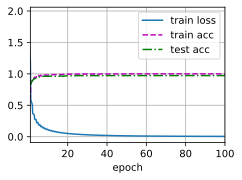

In [31]:
train(net_mfcc, train_iter_mfcc, test_iter_mfcc, num_epochs, lr, d2l.try_gpu())

**(D) Is there a neural-network based alternative to mfcc features?**

TODO: your answer here

No, there is not. We could not make a neural network based model receive such an accuracy just below 100%. Even with this simple two-layer model, MFCC helped us to train the model very well.  

## The end

Well done! Please double check the instructions at the top before you submit your results.